<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
house.shape

(1460, 81)

In [4]:
#Perform any cleaning, feature engineering, and EDA you deem necessary.
house.info()       

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
house.isnull().sum().sort_values(ascending=False).head(20)
#the data has missing values, check to determine the reason

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

In [6]:
house.PoolQC.value_counts() 
#no pool will be null

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

In [7]:
house.MiscFeature.value_counts() 

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

In [8]:
house.BsmtFinType2.value_counts() 

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [9]:
#Replace all nan to none or 0 as they are not missing values, they do not have those features. 
for column in house.columns:
    if house[column].dtypes == object:
        house[column] = house[column].replace(np.nan,"None")
    else:
        house[column] = house[column].replace(np.nan,0)

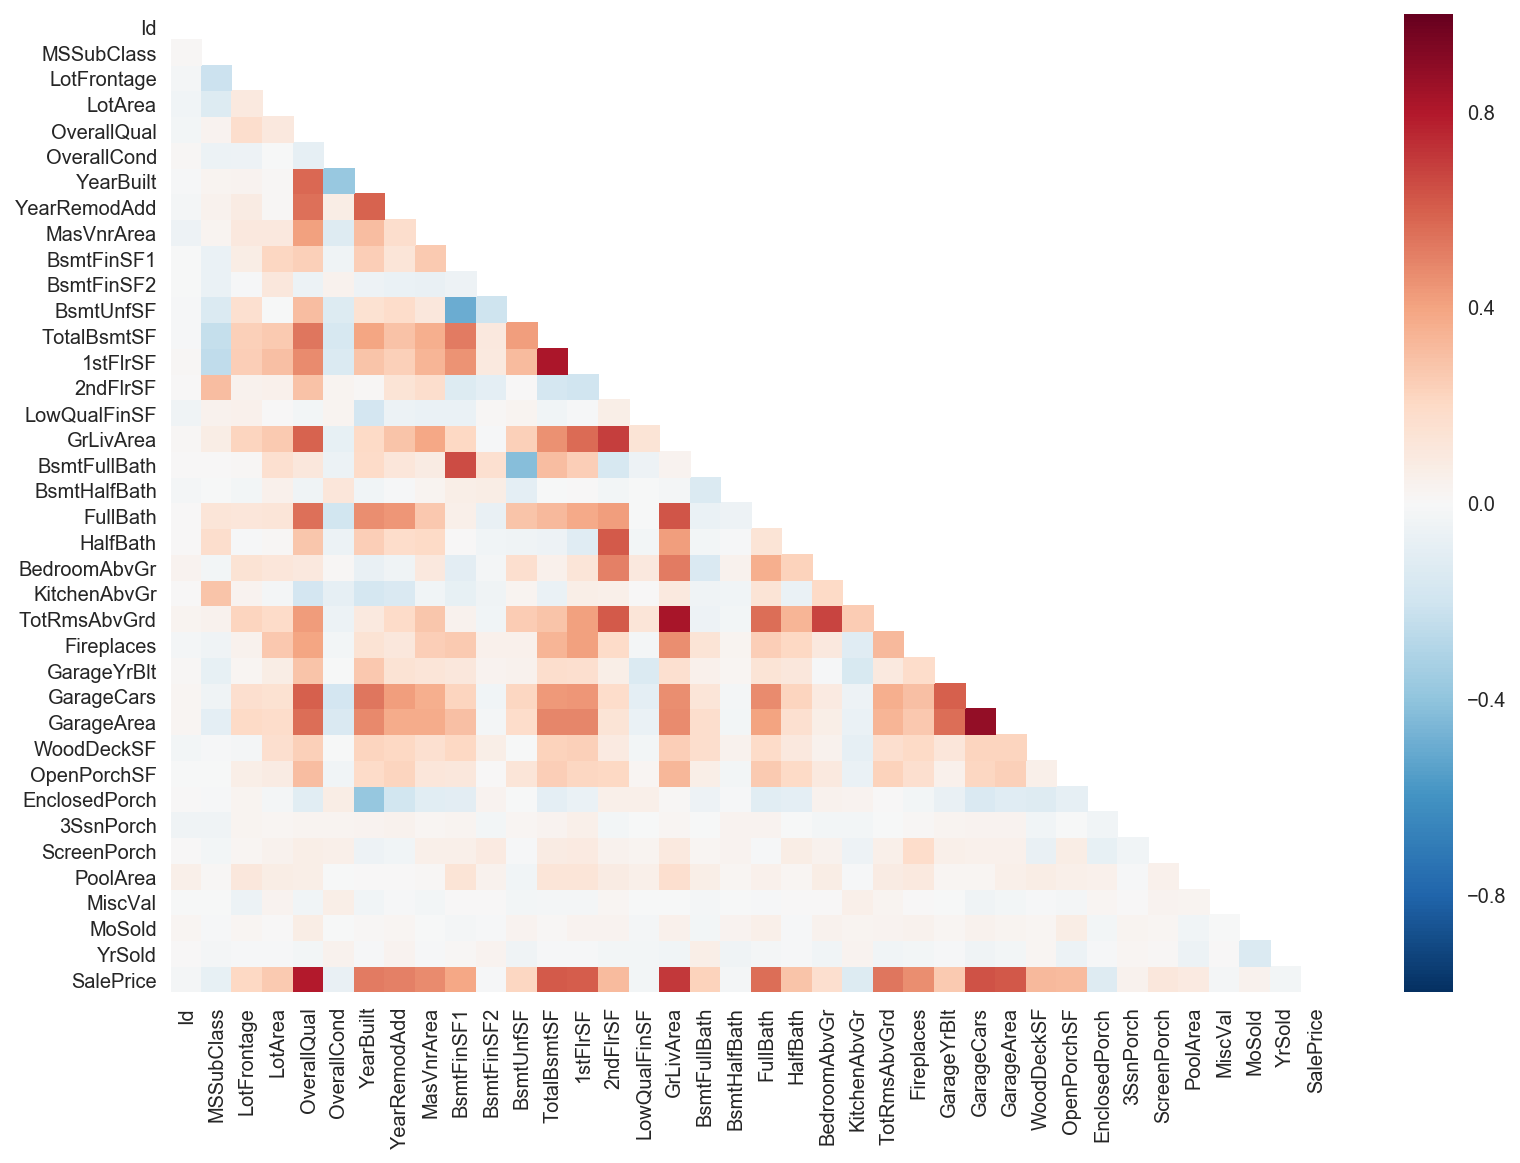

In [10]:
corrs = house.corr()
fig, ax = plt.subplots(figsize=(13,9))
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corrs, mask=mask)
plt.show()

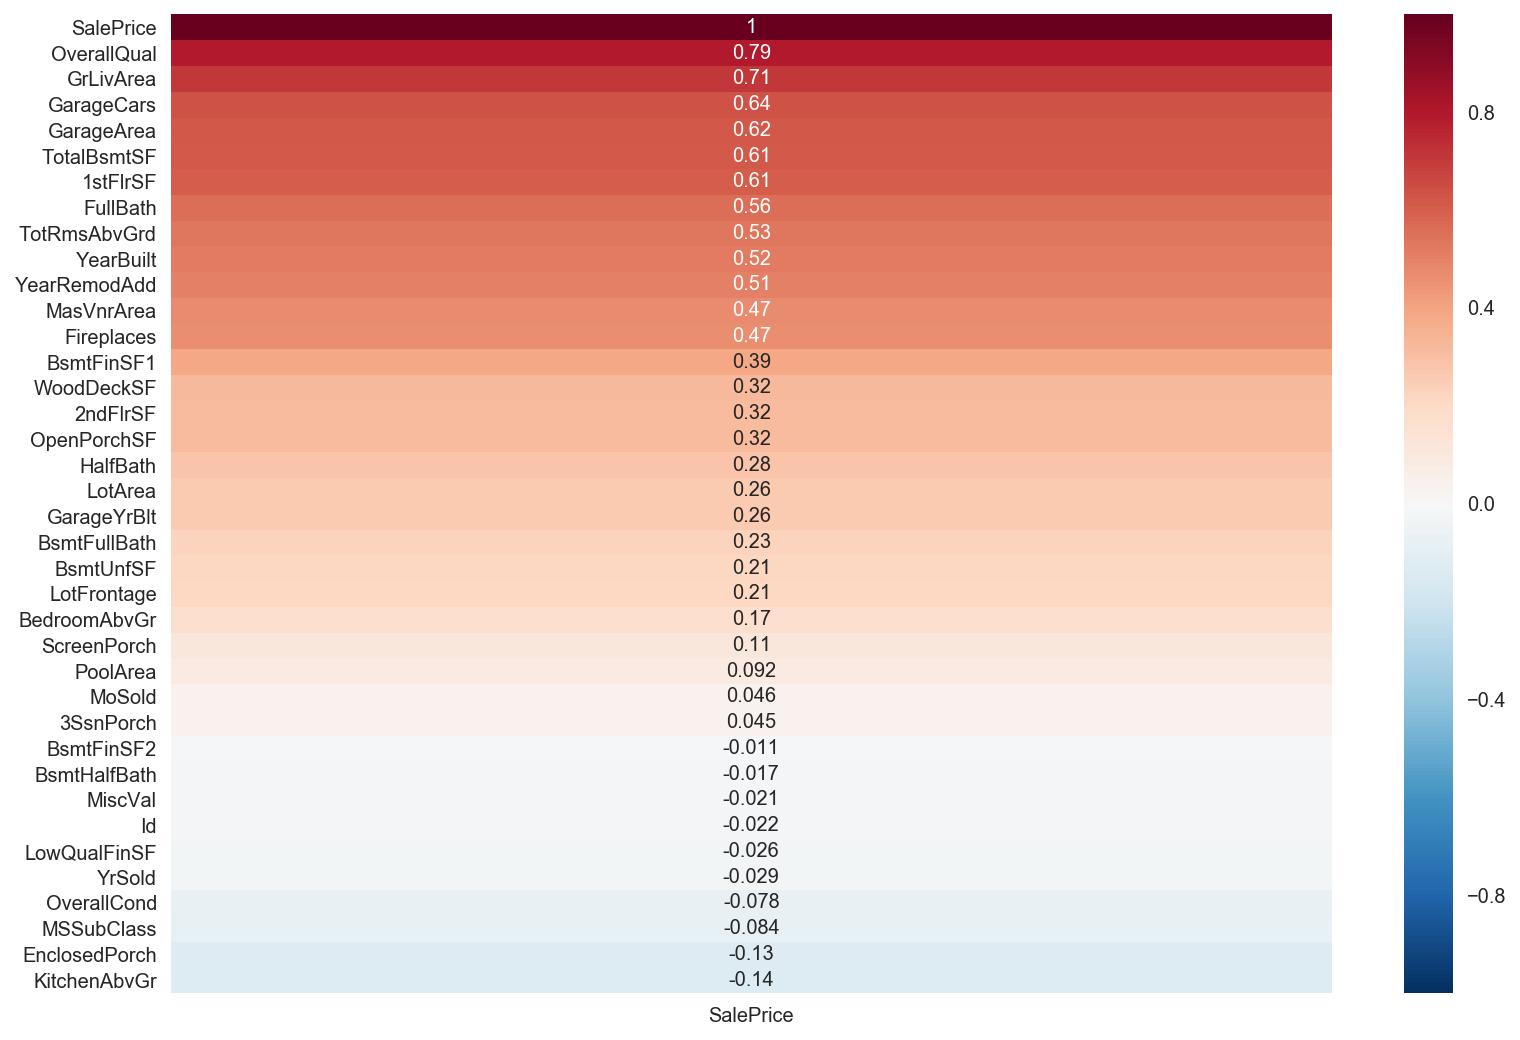

In [11]:
fig, ax = plt.subplots(figsize=(13,9))
sns.heatmap(house.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False), annot=True)

We can observe that OverallQual, GrrLivArea, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF, FullBath and YearBuilt have a high correlation to the sales price

In [12]:
#Be sure to remove any houses that are not residential from the dataset.
#data that are not residential are C (all)
house['MSZoning'].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [13]:
#Remove rows which MSZoning is C(all)
house=house[house['MSZoning']!='C (all)']
house.shape

(1450, 81)

C:\Users\ALICIA\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Distribution for salesprice')

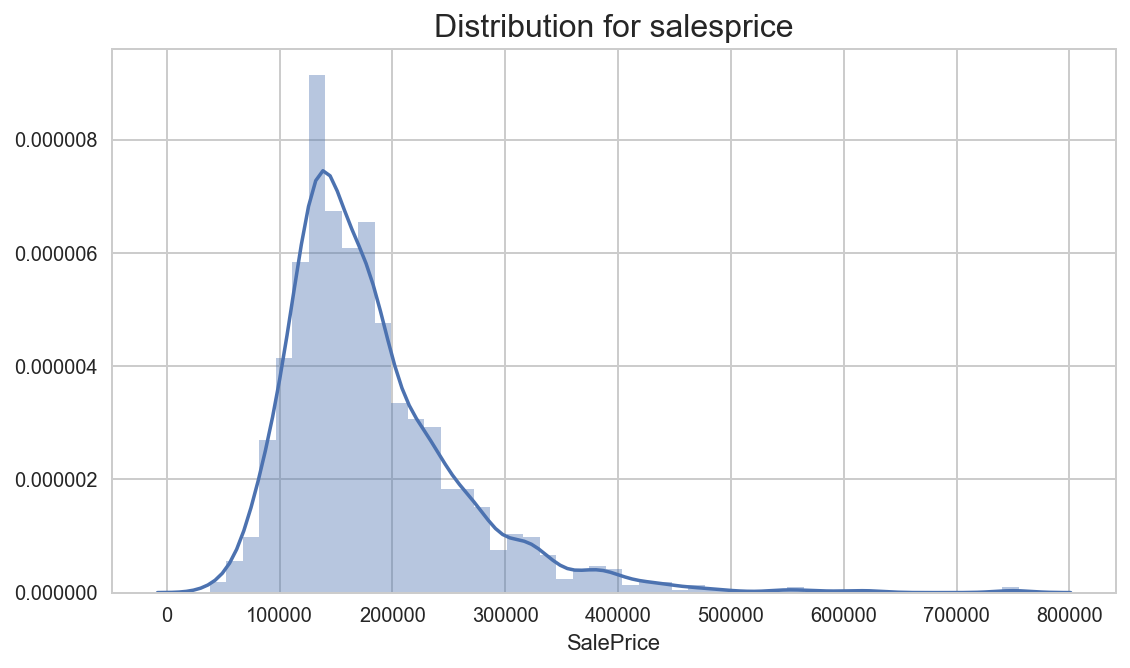

In [14]:
#take a look at the target variable, it is skewed
fig = plt.figure(figsize=(9,5))
ax = fig.gca()
ax = sns.distplot(house['SalePrice'])
ax.set_title('Distribution for salesprice', fontsize=16)

In [15]:
#convert SalePrice to log scale
house['SalePrice']=house['SalePrice'].apply(np.log)

C:\Users\ALICIA\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Distribution for log(salesprice)')

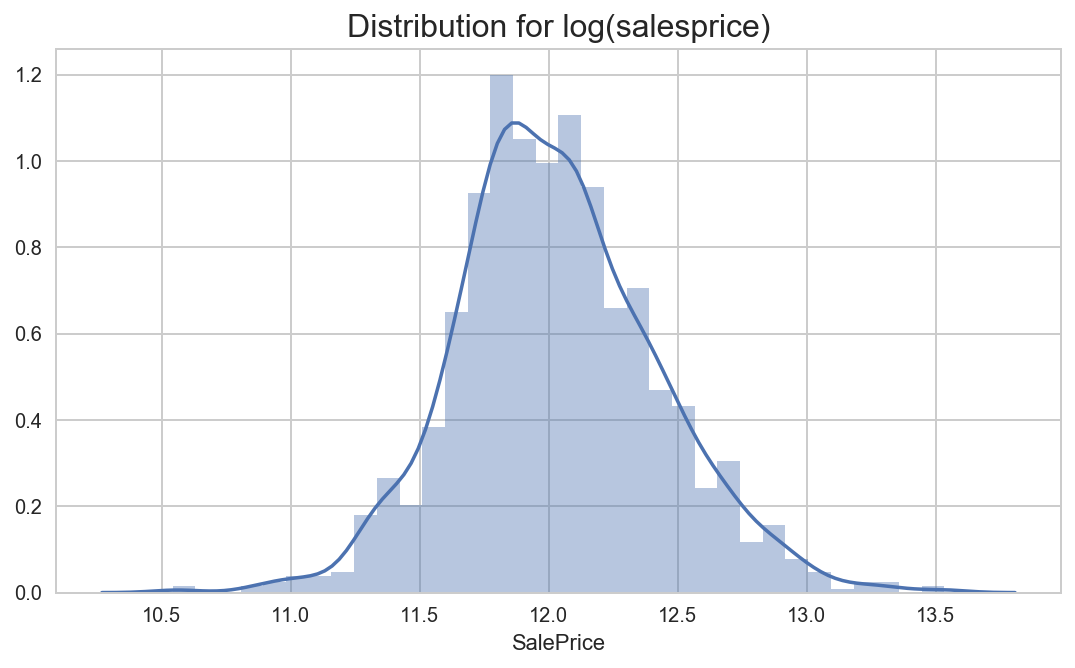

In [16]:
#replot the distribution It fits a normal distribution curve
fig = plt.figure(figsize=(9,5))
ax = fig.gca()
ax = sns.distplot(house['SalePrice'])
ax.set_title('Distribution for log(salesprice)', fontsize=16)

In [17]:
#Identify fixed features that can predict price.
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [18]:
fixed_features =['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street','Alley', 'LotShape', 'LandContour', 'Utilities', 
                 'LotConfig','LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType','HouseStyle', 'YearBuilt', 
                 'YearRemodAdd', 'MasVnrType','MasVnrArea',  'Foundation',  'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
                 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',  '1stFlrSF', '2ndFlrSF','LowQualFinSF', 'GrLivArea', 
                 'BsmtFullBath', 'BsmtHalfBath', 'FullBath','HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 
                 'Functional', 'Fireplaces', 'GarageType','GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',  
                 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF','EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
                 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType','SaleCondition']
target=['SalePrice']

In [19]:
#renovatable: quality and condition features, roof and exterior features, heating and electrical
renovatable_features=['OverallQual','OverallCond','RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd','ExterQual', 'ExterCond',
             'BsmtQual','BsmtCond','Heating','HeatingQC', 'CentralAir', 'Electrical','GarageQual','GarageCond','FireplaceQu', 
             'KitchenQual']

In [20]:
house[fixed_features].head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,0,None,None,None,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,None,None,None,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,0,None,None,None,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,0,None,None,None,0,12,2008,WD,Normal


In [21]:
#see the predictors, there are categorical and numerical
fixed=house[fixed_features]
fixed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 61 columns):
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1450 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            1450 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
MasVnrType       1450 non-null object
MasVnrArea       1450 non-null float64
Foundation       1450 non-null object
BsmtExposure     1450 non-null object
BsmtFinType1     1450 non-null object
BsmtFinSF1       1450

In [22]:
#spilt the fix features to categorical vs numerical, have to convert all the categorical to dummy
categorical = [column for column in fixed.columns if fixed[column].dtypes == object]
house_final = [column for column in fixed.columns if fixed[column].dtypes != object]
house_dummy = pd.get_dummies(fixed[categorical], drop_first=True)
print(house_dummy.shape)

(1450, 134)


In [23]:
#concat two df along the y axis 
combined = pd.concat([house[house_final],house_dummy,house[target] ], axis=1)
print(combined.shape)
combined.head()

(1450, 169)


,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,60,65.0,8450,2003,2003,196.0,706,0,150,856,...,0,0,0,1,0,0,0,1,0,12.247694
1,20,80.0,9600,1976,1976,0.0,978,0,284,1262,...,0,0,0,1,0,0,0,1,0,12.109011
2,60,68.0,11250,2001,2002,162.0,486,0,434,920,...,0,0,0,1,0,0,0,1,0,12.317167
3,70,60.0,9550,1915,1970,0.0,216,0,540,756,...,0,0,0,1,0,0,0,0,0,11.849398
4,60,84.0,14260,2000,2000,350.0,655,0,490,1145,...,0,0,0,1,0,0,0,1,0,12.429216


Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF'],
      dtype='object')


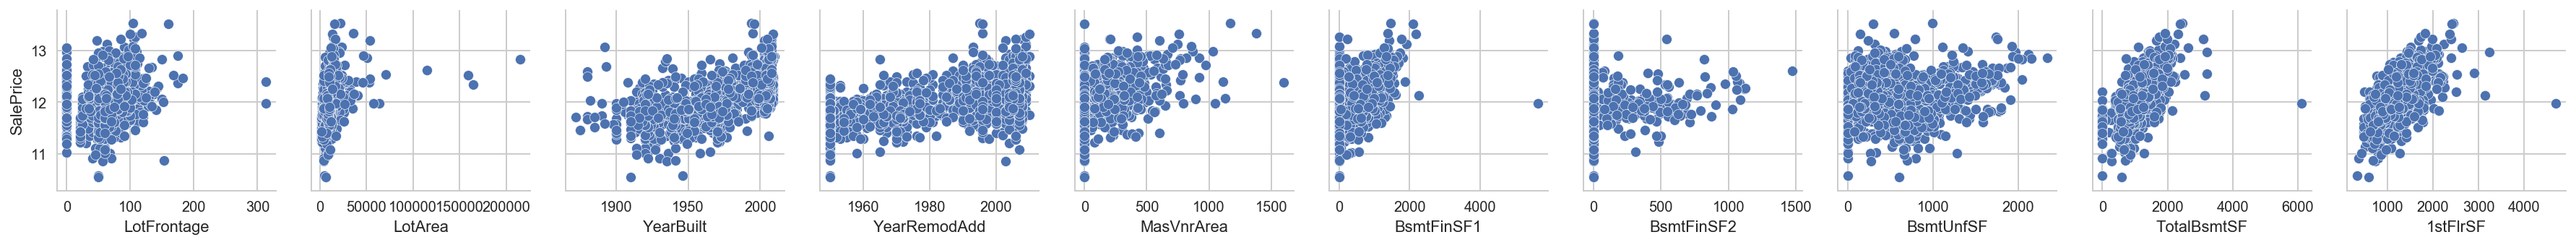

In [24]:
#Check the distribution of some of the predictors
X1 = combined.columns[1:11]
print(X1)
pp = sns.pairplot(data=combined,
                  x_vars=X1,
                  y_vars=['SalePrice'])


TotalBsmtSF and 1stFlrSF have a strong linear relationship with respect to sales price

Index(['2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd'],
      dtype='object')


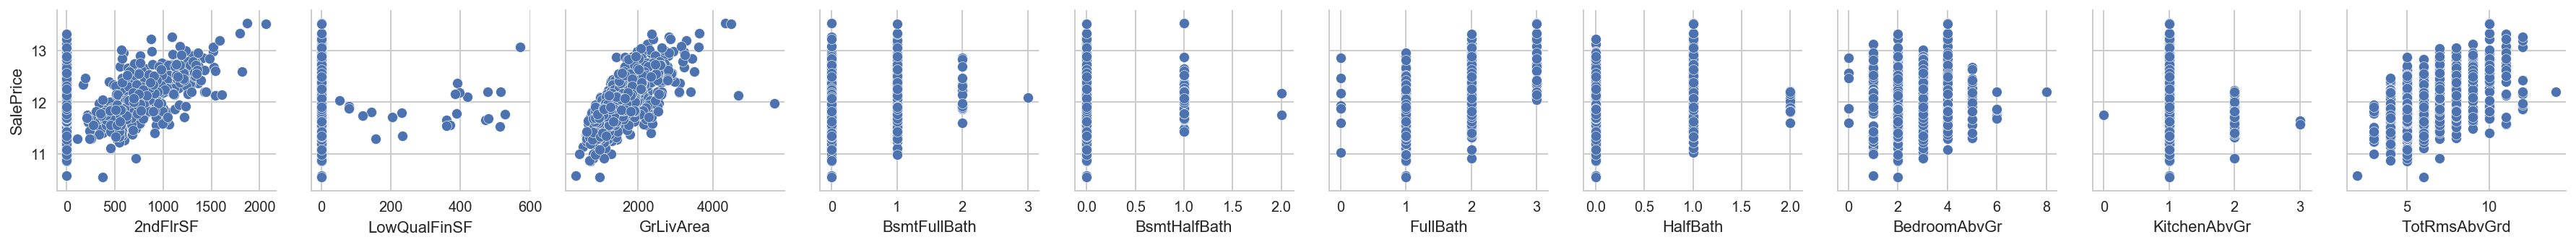

In [25]:
X1 = combined.columns[11:21]
print(X1)
pp = sns.pairplot(data=combined,
                  x_vars=X1,
                  y_vars=['SalePrice'])

2ndFlrSF and GrLivArea have a strong linear relationship with respect to sales price

In [26]:
combined.corr().abs()[['SalePrice']].sort_values(by='SalePrice', ascending=False).head(11)

,SalePrice
SalePrice,1.000000
GrLivArea,0.704826
GarageCars,0.687597
GarageArea,0.663532
TotalBsmtSF,0.614449
1stFlrSF,0.596437
FullBath,0.591312
YearBuilt,0.582793
YearRemodAdd,0.559003
TotRmsAbvGrd,0.536118


There are highly correlated predictors and we can start modelling now

In [27]:
#Modelling

In [28]:
#Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
#Separate out the train set(X_train) and the test set(X_test)
train = combined.loc[combined['YrSold']<2010]
test = combined.loc[combined['YrSold']>=2010]
y_train = train['SalePrice']
X_train = train.drop(['SalePrice'],axis=1)
y_test = test['SalePrice']
X_test = test.drop(['SalePrice'],axis=1)

In [29]:
print('y_train', y_train.shape)
print('y_test', y_test.shape)
print('X_train', X_train.shape)
print('X_test', X_test.shape)

y_train (1278,)
y_test (172,)
X_train (1278, 168)
X_test (172, 168)


In [30]:
#standardize the predictor columns
ss = StandardScaler()
X_train_s = ss.fit_transform(X_train)

In [31]:
X_test_s=ss.transform(X_test)

In [32]:
#perform linear regression on the predictor
lr = LinearRegression()
lr.fit(X_train_s,y_train) 
linreg_scores = lr.score(X_test_s, y_test)
y_pred = lr.predict(X_test_s)
residuals = abs(y_test-y_pred)

print("Cross-validated scores:", linreg_scores)
print("Mean Cross-validated scores:", np.mean(linreg_scores))
print("Std Cross-validated scores:", np.std(linreg_scores))
print("Mean residuals:", residuals.mean())

Cross-validated scores: 0.902192244165
Mean Cross-validated scores: 0.902192244165
Std Cross-validated scores: 0.0
Mean residuals: 0.09337061850288898


C:\Users\ALICIA\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


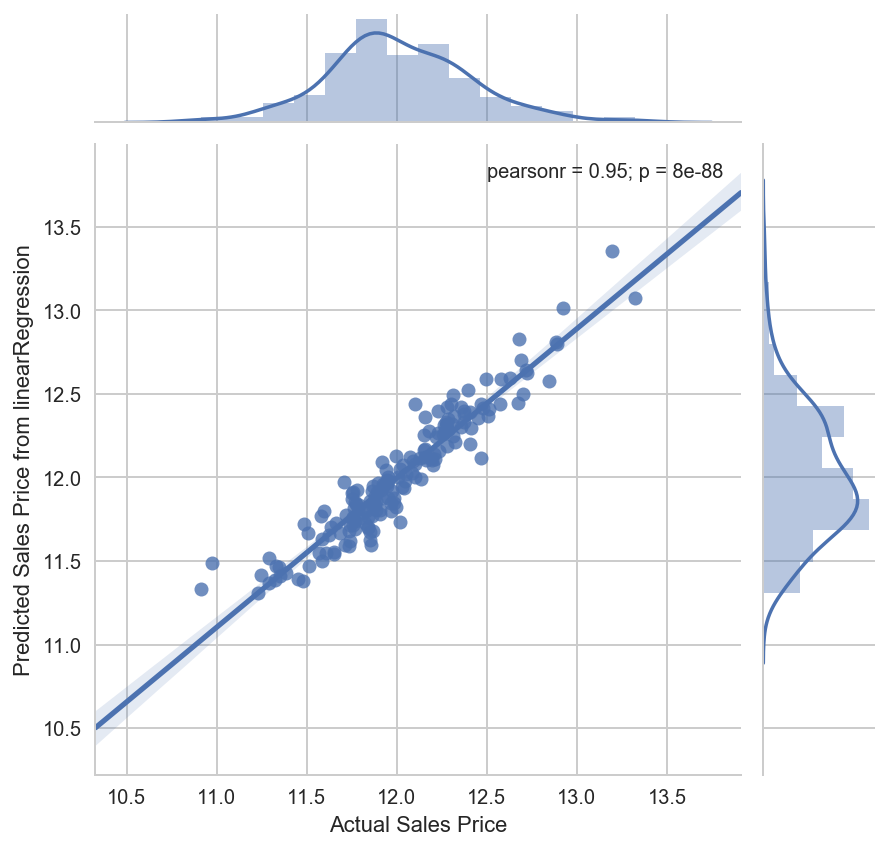

In [33]:
sns.jointplot(y_test,y_pred, kind='reg').set_axis_labels('Actual Sales Price', 'Predicted Sales Price from linearRegression')

In [34]:
lr = LinearRegression()
lr.fit(X_train,y_train) 
linear_scores = cross_val_score(LinearRegression(), X_train, y_train, cv=10)
y_pred = lr.predict(X_test)
residuals = abs(y_test-y_pred)

print("Cross-validated scores:", linear_scores)
print("Mean Cross-validated scores:", np.mean(linear_scores))
print("Std Cross-validated scores:", np.std(linear_scores))
print("Mean residuals:", residuals.mean())

Cross-validated scores: [ 0.88506347  0.88282827  0.89257445  0.75911742  0.89030783  0.50704372
  0.87023114  0.84964583  0.41338654 -0.43054216]
Mean Cross-validated scores: 0.651965649818
Std Cross-validated scores: 0.396267086008
Mean residuals: 0.09339254216363532


We should not use linear Regression as the cross validated scores shows that the model is overfitting as there are negative cross validated scores.

In [35]:
#perform ridge regression on the predictor
ridge_alphas = np.logspace(-2, 7, 50)
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=12)
optimal_ridge.fit(X_train_s, y_train)
print("best alpha parameter:", optimal_ridge.alpha_)
ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge_scores = cross_val_score(ridge, X_train_s, y_train, cv=10)
y_pred = cross_val_predict(ridge, X_test_s, y_test, cv=10)
residuals = abs(y_test-y_pred)

print("Cross-validated scores:", ridge_scores)
print("Mean Cross-validated scores:", np.mean(ridge_scores))
print("Std Cross-validated scores:", np.std(ridge_scores))
print("Mean residuals:", residuals.mean())

best alpha parameter: 596.362331659
Cross-validated scores: [ 0.90460188  0.87774746  0.88282744  0.77528608  0.87421939  0.83691572
  0.85912264  0.860801    0.58892307  0.82840987]
Mean Cross-validated scores: 0.828885455518
Std Cross-validated scores: 0.0869124947672
Mean residuals: 0.1338362486483665


In [36]:
#perform lasso regression on the predictor
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_train_s, y_train)
print("best alpha parameter:", optimal_lasso.alpha_)
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, X_train_s, y_train, cv=10)
y_pred = cross_val_predict(lasso, X_test_s, y_test, cv=10)
residuals = abs(y_test-y_pred)

print("Cross-validated scores:", lasso_scores)
print("Mean Cross-validated scores:", np.mean(lasso_scores))
print("Std Cross-validated scores:", np.std(lasso_scores))
print("Mean residuals:", residuals.mean())

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

best alpha parameter: 0.00637872387738
Cross-validated scores: [ 0.90670589  0.9055205   0.88946937  0.78319141  0.88046457  0.7995204
  0.86815601  0.85384808  0.48680503  0.80277703]
Mean Cross-validated scores: 0.817645829115
Std Cross-validated scores: 0.118242420784
Mean residuals: 0.10074249812204918


C:\Users\ALICIA\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


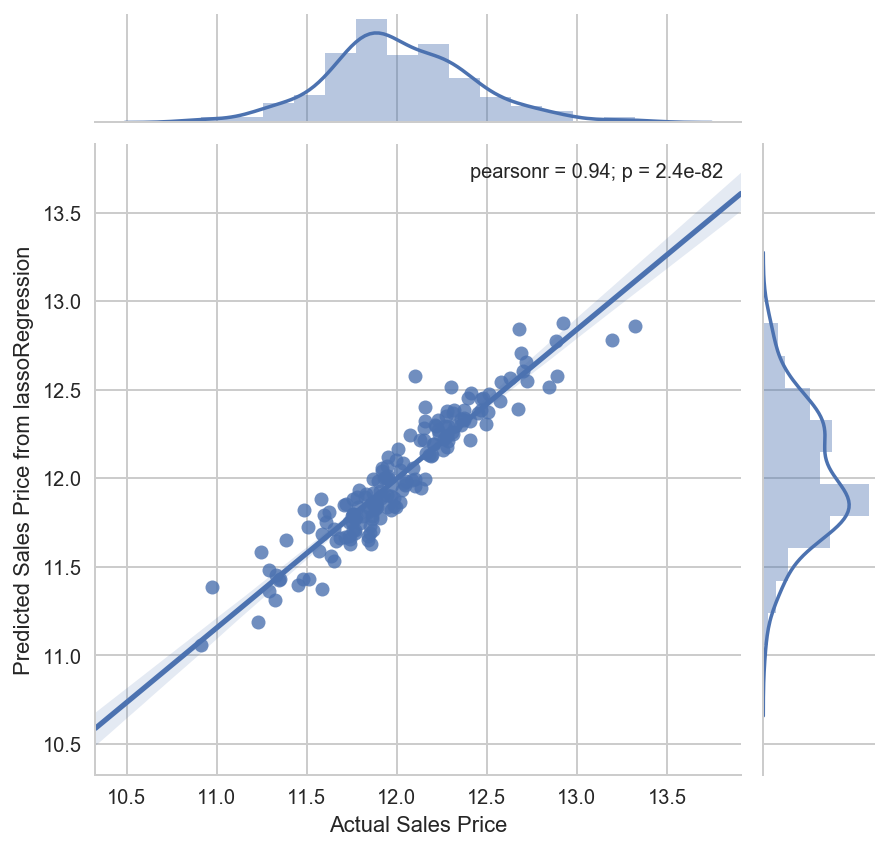

In [37]:
sns.jointplot(y_test,y_pred, kind='reg').set_axis_labels('Actual Sales Price', 'Predicted Sales Price from lassoRegression')

In [38]:
#check the coefficients for variables in the lasso
lasso.fit(X_test_s, y_test)
lasso_coefs = pd.DataFrame({'variable':X_test.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
print(lasso_coefs.head(15))
print('Percent variables zeroed out:', (np.sum((lasso.coef_ == 0))/float(len(lasso.coef_)))*100,"%")

     abs_coef      coef              variable
13   0.131266  0.131266             GrLivArea
24   0.079963  0.079963            GarageArea
3    0.061938  0.061938             YearBuilt
9    0.054218  0.054218           TotalBsmtSF
59   0.039745 -0.039745  Neighborhood_Edwards
58   0.039703  0.039703  Neighborhood_Crawfor
4    0.038003  0.038003          YearRemodAdd
2    0.033414  0.033414               LotArea
107  0.030367  0.030367      Foundation_PConc
56   0.024395  0.024395  Neighborhood_ClearCr
21   0.023690  0.023690            Fireplaces
62   0.020805 -0.020805  Neighborhood_MeadowV
141  0.018749 -0.018749      GarageFinish_Unf
43   0.017444  0.017444       LandContour_HLS
6    0.017419  0.017419            BsmtFinSF1
Percent variables zeroed out: 67.2619047619 %


In [39]:
#perform elastic net regression on the predictor
l1_ratios = np.linspace(0.01, 1.0, 25)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=300, cv=10)
optimal_enet.fit(X_train_s, y_train)
print("best alpha parameter:", optimal_enet.alpha_)
print("optimal l1_ratio:", optimal_enet.l1_ratio_) #(0 = all ridge, 1 = all lasso)
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
enet_scores = cross_val_score(enet, X_train_s, y_train, cv=10)
y_pred = cross_val_predict(enet, X_test_s, y_test, cv=10)
residuals = abs(y_test-y_pred)

print("Cross-validated scores:", enet_scores)
print("Mean Cross-validated scores:", np.mean(enet_scores))
print("Std Cross-validated scores:", np.std(enet_scores))
print("Mean residuals:", residuals.mean())

best alpha parameter: 0.366226834605
optimal l1_ratio: 0.01
Cross-validated scores: [ 0.90950618  0.88583279  0.88432099  0.78745936  0.87462668  0.8490331
  0.86197384  0.86045988  0.58717047  0.82575923]
Mean Cross-validated scores: 0.832614252317
Std Cross-validated scores: 0.0879879316391
Mean residuals: 0.10273286181613352


In [40]:
#check the coefficients for variables in the elastic net
enet.fit(X_test_s, y_test)
enet_coefs = pd.DataFrame({'variable':X_test.columns,
                            'coef':enet.coef_,
                            'abs_coef':np.abs(enet.coef_)})

enet_coefs.sort_values('abs_coef', inplace=True, ascending=False)
print(enet_coefs.head(15))

     abs_coef      coef              variable
13   0.043220  0.043220             GrLivArea
24   0.038554  0.038554            GarageArea
9    0.037566  0.037566           TotalBsmtSF
10   0.035065  0.035065              1stFlrSF
59   0.031653 -0.031653  Neighborhood_Edwards
23   0.031037  0.031037            GarageCars
4    0.029584  0.029584          YearRemodAdd
3    0.029468  0.029468             YearBuilt
20   0.027046  0.027046          TotRmsAbvGrd
6    0.026073  0.026073            BsmtFinSF1
21   0.025142  0.025142            Fireplaces
107  0.022930  0.022930      Foundation_PConc
56   0.022219  0.022219  Neighborhood_ClearCr
58   0.020878  0.020878  Neighborhood_Crawfor
16   0.020156  0.020156              FullBath


Characterize your model. How well does it perform? What are the best estimates of price?

**Summary of scores:**
<br>
linear: -
<br>
Ridge: 0.828885455518
<br>
Lasso: 0.817645829115
<br>
****Elastic Net: 0.832614252317****

The elastic net model gave the best R2 score.

Looking at the elastic net coefficients, the best estimates of price are the following fixed features:<br>
GrLivArea, GarageArea, TotalBsmtSF, 1stFlrSF, GarageCars as they have larger positive coefficients. <br>
Neighborhood_Edwards actually has a big reduced effect in the price. 


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [41]:
# Evaluate the effect in dollars of the renovate-able features.
#The effects must be on the variance in price remaining from the first model.
#Get residuals from the first question on the best elastic net model by re-running the model
l1_ratios = np.linspace(0.01, 1.0, 25)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=300, cv=10)
optimal_enet.fit(X_train_s, y_train)
print("best alpha parameter:", optimal_enet.alpha_)
print("optimal l1_ratio:", optimal_enet.l1_ratio_) #(0 = all ridge, 1 = all lasso)
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
enet_scores = cross_val_score(enet, X_train_s, y_train, cv=10)
y_pred = cross_val_predict(enet, X_test_s, y_test, cv=10)
residuals = y_test-y_pred

print("Cross-validated scores:", enet_scores)
print("Mean Cross-validated scores:", np.mean(enet_scores))
print("Std Cross-validated scores:", np.std(enet_scores))
print("Mean residuals:", residuals.mean())

best alpha parameter: 0.366226834605
optimal l1_ratio: 0.01
Cross-validated scores: [ 0.90950618  0.88583279  0.88432099  0.78745936  0.87462668  0.8490331
  0.86197384  0.86045988  0.58717047  0.82575923]
Mean Cross-validated scores: 0.832614252317
Std Cross-validated scores: 0.0879879316391
Mean residuals: 0.0010726141069351109


In [42]:
residuals.head()

16   -0.037906
24    0.117002
26    0.010644
27    0.090315
33   -0.025402
Name: SalePrice, dtype: float64

C:\Users\ALICIA\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Distribution for residuals')

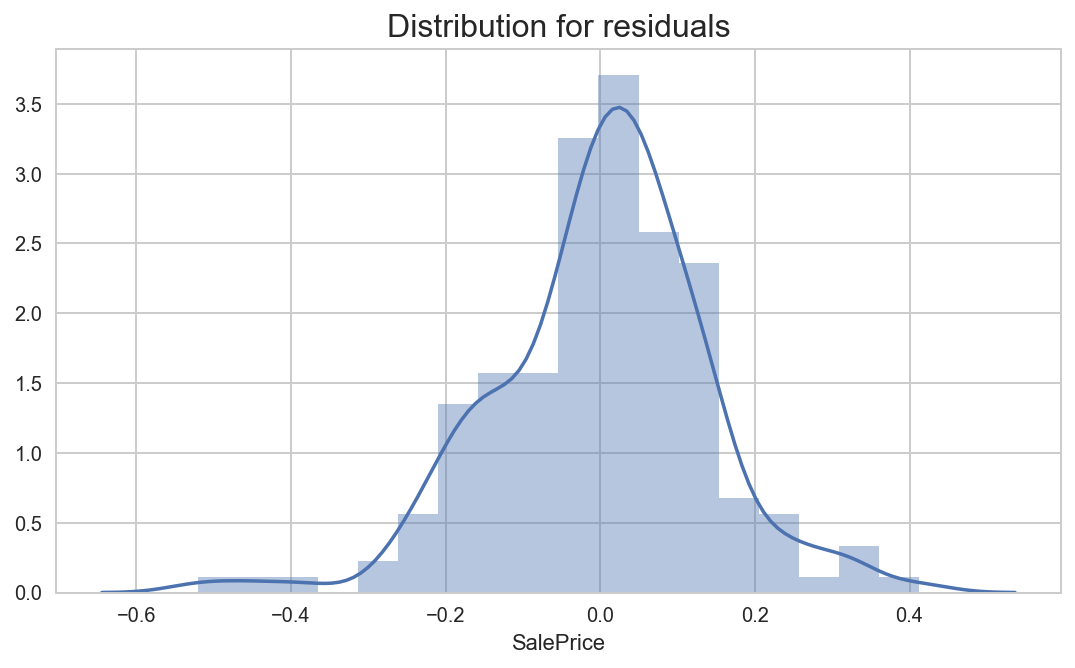

In [43]:
#residual become the target variable
fig = plt.figure(figsize=(9,5))
ax = fig.gca()
ax = sns.distplot(residuals)
ax.set_title('Distribution for residuals', fontsize=16)

In [44]:
residuals.head()

16   -0.037906
24    0.117002
26    0.010644
27    0.090315
33   -0.025402
Name: SalePrice, dtype: float64

The residuals follow a normal distribution, hence we can proceed on to model on the residuals.

In [45]:
house[renovatable_features].head()

,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,BsmtQual,BsmtCond,Heating,HeatingQC,CentralAir,Electrical,GarageQual,GarageCond,FireplaceQu,KitchenQual
0,7,5,Gable,CompShg,VinylSd,VinylSd,Gd,TA,Gd,TA,GasA,Ex,Y,SBrkr,TA,TA,None,Gd
1,6,8,Gable,CompShg,MetalSd,MetalSd,TA,TA,Gd,TA,GasA,Ex,Y,SBrkr,TA,TA,TA,TA
2,7,5,Gable,CompShg,VinylSd,VinylSd,Gd,TA,Gd,TA,GasA,Ex,Y,SBrkr,TA,TA,TA,Gd
3,7,5,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,TA,Gd,GasA,Gd,Y,SBrkr,TA,TA,Gd,Gd
4,8,5,Gable,CompShg,VinylSd,VinylSd,Gd,TA,Gd,TA,GasA,Ex,Y,SBrkr,TA,TA,TA,Gd


In [46]:
renovatable=house[renovatable_features]

In [47]:
renovatable.shape

(1450, 18)

In [48]:
renovatable.columns

Index(['OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'GarageQual',
       'GarageCond', 'FireplaceQu', 'KitchenQual'],
      dtype='object')

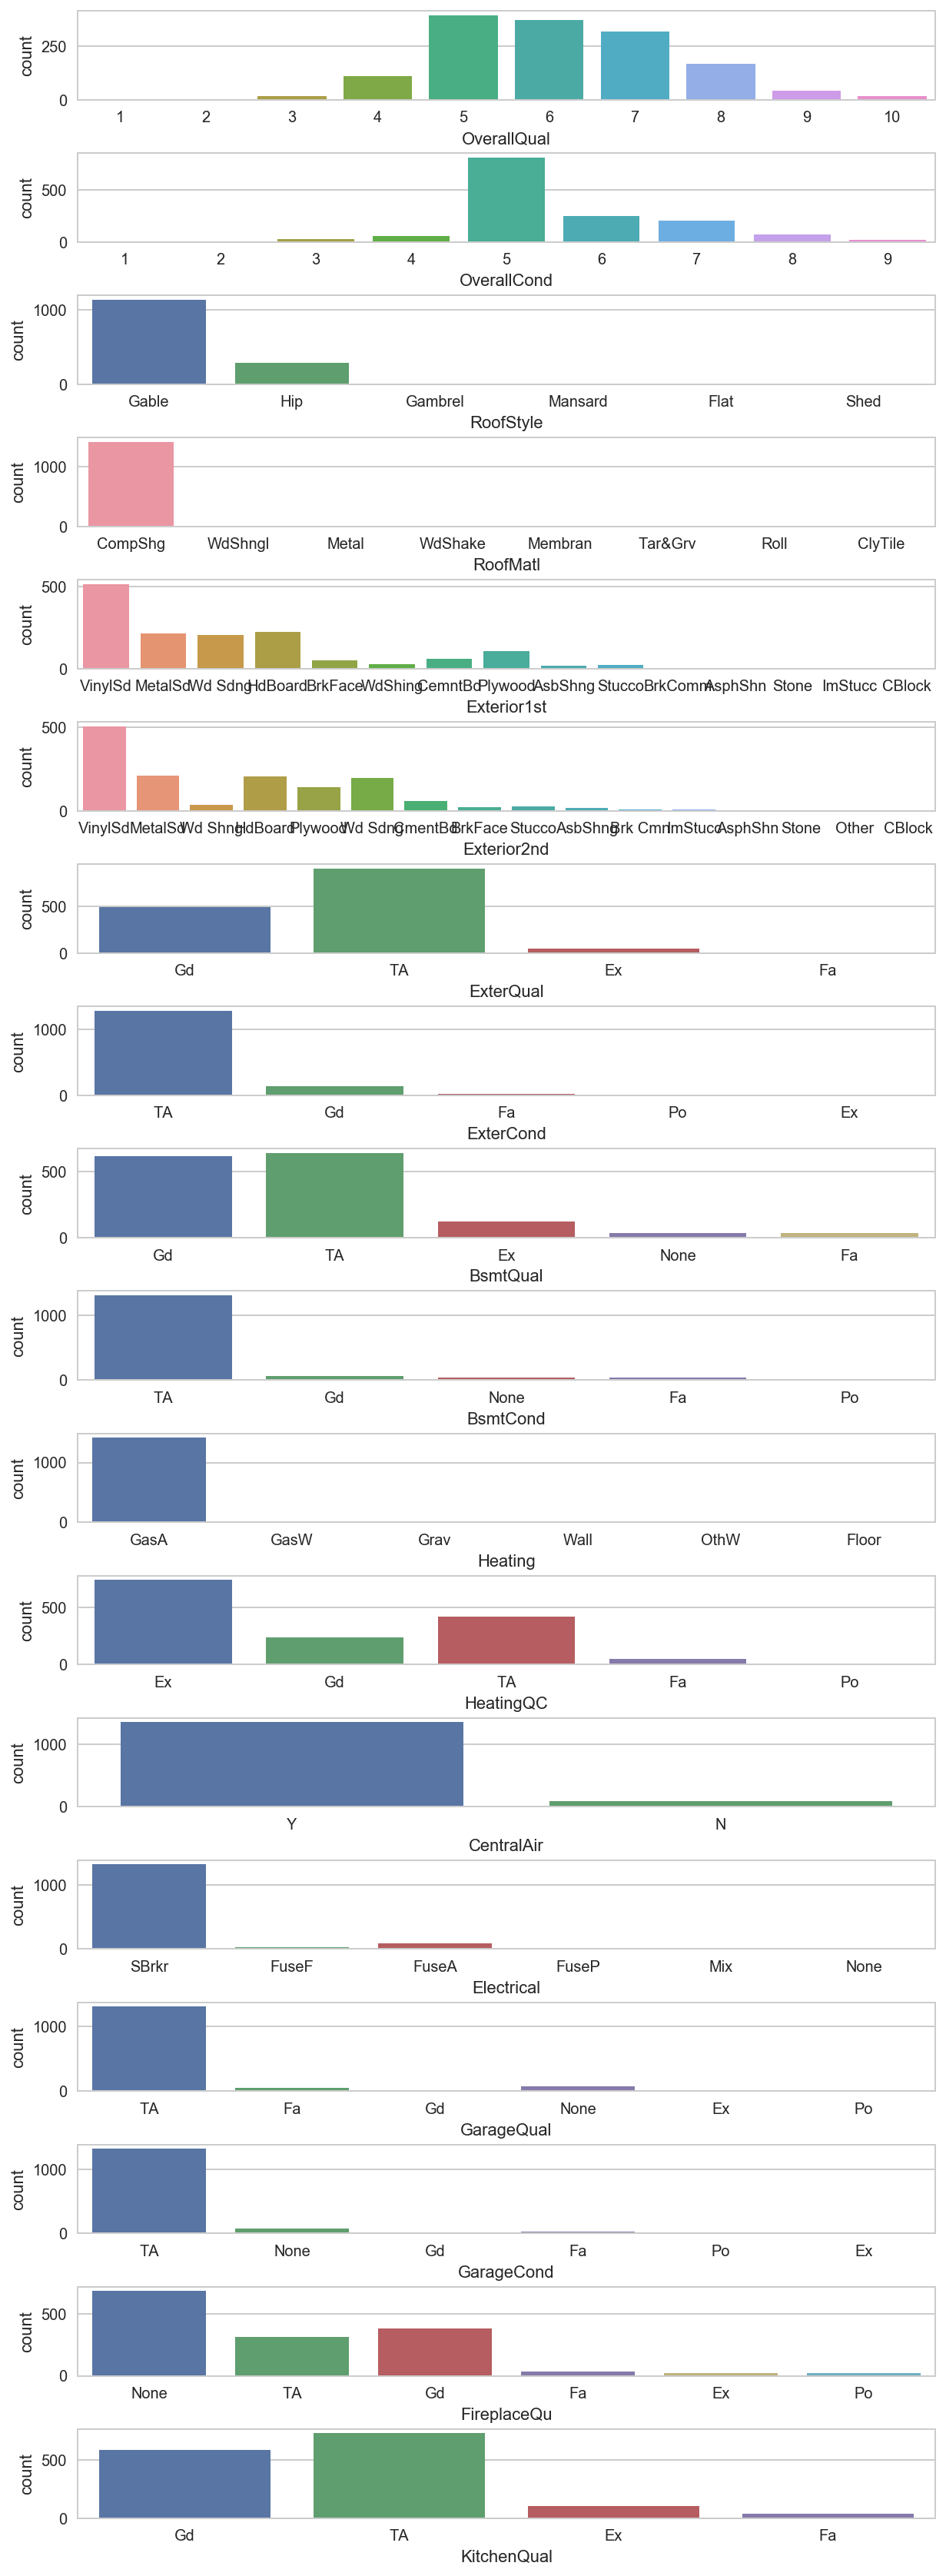

In [49]:
#Take a look at the distribution of the renovatable columns
fig, axs = plt.subplots(18,1, figsize=(10, 30))
plt.subplots_adjust(hspace= .6)

for i in range(0,len(renovatable_features)):
    sns.countplot(house[renovatable_features[i]], ax=axs[i])
    ax.title = renovatable_features[i]

In [50]:
#from the chart can remove RoofMatl, BsmtCond, Heating, Electrical, GarageQual,GarageCond 

In [51]:
renovatable=renovatable.copy()
renovatable.drop(['RoofMatl', 'ExterCond','BsmtCond', 'Heating', 'Electrical', 'GarageQual' , 'GarageCond' ],axis=1, inplace=True)

In [52]:
renovatable.shape

(1450, 11)

In [53]:
#spilt the renovatable features to categorical vs numerical, have to convert all the categorical to dummy
categorical = [column for column in renovatable.columns if renovatable[column].dtypes == object]
house_final = [column for column in renovatable.columns if renovatable[column].dtypes != object]
house_dummy = pd.get_dummies(renovatable[categorical], drop_first=True)
print(house_dummy.shape)

(1450, 54)


In [54]:
#concat two df along the y axis 
combined = pd.concat([renovatable[house_final],house_dummy], axis=1)
print(combined.shape)
combined.head()

(1450, 56)


,OverallQual,OverallCond,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,...,HeatingQC_TA,CentralAir_Y,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA
0,7,5,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
1,6,8,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
2,7,5,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
3,7,5,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
4,8,5,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0


In [55]:
#Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
#Separate out the train set(X_train) and the test set(X_test)

y_pred = cross_val_predict(lasso, X_train_s, y_train, cv=10)
y_train = (y_train-y_pred)
X_train = (combined[house['YrSold']<2010])

y_pred = cross_val_predict(lasso, X_test_s, y_test, cv=10)
y_test = (y_test-y_pred)
X_test = (combined[house['YrSold']>=2010])

In [56]:
y_test.head()

16    0.022326
24    0.106722
26    0.021685
27    0.066859
33   -0.032115
Name: SalePrice, dtype: float64

In [57]:
X_test.head()

,OverallQual,OverallCond,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,...,HeatingQC_TA,CentralAir_Y,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA
16,6,7,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
24,5,8,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
26,5,7,1,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,1,0
27,8,5,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
33,5,5,0,0,1,0,0,0,0,1,...,0,1,0,1,0,0,0,0,1,0


In [58]:
#perform ridge regression on the predictor
ridge_alphas = np.logspace(-2, 7, 50)
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=12)
optimal_ridge.fit(X_train, y_train)
print("best alpha parameter:", optimal_ridge.alpha_)
ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge_scores = cross_val_score(ridge, X_train, y_train, cv=10)
y_pred = cross_val_predict(ridge, X_test, y_test, cv=10)
residuals = abs(y_test-y_pred)

print("Cross-validated scores:", ridge_scores)
print("Mean Cross-validated scores:", np.mean(ridge_scores))
print("Std Cross-validated scores:", np.std(ridge_scores))
print("Mean residuals:", residuals.mean())

best alpha parameter: 71.9685673001
Cross-validated scores: [ 0.06780429  0.27286812  0.22033362  0.07778027  0.16678268  0.09316347
  0.07522686  0.31994173 -0.04241444  0.12815593]
Mean Cross-validated scores: 0.137964250038
Std Cross-validated scores: 0.102980759645
Mean residuals: 0.0957385869511735


In [59]:
#perform lasso regression on the predictor
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_train, y_train)
print("best alpha parameter:", optimal_lasso.alpha_)
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, X_train, y_train, cv=10)
y_pred = cross_val_predict(lasso, X_test, y_test,cv=10)
residuals = abs(y_test-y_pred)

print("Cross-validated scores:", lasso_scores)
print("Mean Cross-validated scores:", np.mean(lasso_scores))
print("Std Cross-validated scores:", np.std(lasso_scores))
print("Mean residuals:", residuals.mean())

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

best alpha parameter: 0.00192591894864
Cross-validated scores: [ 0.0672947   0.29511886  0.21591576  0.10583182  0.17211946  0.09522638
  0.05840112  0.30475081 -0.03050736  0.13544655]
Mean Cross-validated scores: 0.141959811493
Std Cross-validated scores: 0.101079777798
Mean residuals: 0.09884186765401315


In [60]:
#check the coefficients for variables in the lasso
lasso.fit(X_test, y_test)
lasso_coefs = pd.DataFrame({'variable':combined.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
print(lasso_coefs.head(15))
print('Percent variables zeroed out:', (np.sum((lasso.coef_ == 0))/float(len(lasso.coef_)))*100,"%")

    abs_coef      coef             variable
54  0.062284 -0.062284       KitchenQual_Gd
30  0.048492 -0.048492  Exterior2nd_Plywood
37  0.041319 -0.041319         ExterQual_Gd
0   0.034778  0.034778          OverallQual
55  0.034647 -0.034647       KitchenQual_TA
1   0.029505  0.029505          OverallCond
9   0.028457  0.028457  Exterior1st_BrkFace
4   0.025242  0.025242        RoofStyle_Hip
46  0.023972 -0.023972         HeatingQC_TA
12  0.014619 -0.014619  Exterior1st_HdBoard
44  0.012514 -0.012514         HeatingQC_Gd
42  0.011439 -0.011439          BsmtQual_TA
40  0.010705 -0.010705          BsmtQual_Gd
47  0.007187  0.007187         CentralAir_Y
2   0.006929 -0.006929      RoofStyle_Gable
Percent variables zeroed out: 67.8571428571 %


In [61]:
#perform elastic net regression on the predictor
l1_ratios = np.linspace(0.01, 1.0, 25)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=300, cv=10)
optimal_enet.fit(X_train, y_train)
print("best alpha parameter:", optimal_enet.alpha_)
print("optimal l1_ratio:", optimal_enet.l1_ratio_) #(0 = all ridge, 1 = all lasso)
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
enet_scores = cross_val_score(enet, X_train, y_train, cv=10)
y_pred = cross_val_predict(enet, X_test, y_test, cv=10)
residuals = abs(y_test-y_pred)

print("Cross-validated scores:", enet_scores)
print("Mean Cross-validated scores:", np.mean(enet_scores))
print("Std Cross-validated scores:", np.std(enet_scores))
print("Mean residuals:", residuals.mean())

best alpha parameter: 0.00191755548105
optimal l1_ratio: 1.0
Cross-validated scores: [ 0.06744547  0.29496018  0.21609776  0.10575218  0.17217222  0.09525189
  0.05839472  0.30480156 -0.03054975  0.13540825]
Mean Cross-validated scores: 0.141973446919
Std Cross-validated scores: 0.101077383973
Mean residuals: 0.09885851197329912


Q: How would your company use this second model and its coefficients to determine whether they should buy a property or not? <br>
A: The company will use the second model to determine if there is a need to renovate the house before selling to fetch a higher sales price. The coefficient of the 2nd model will determine how much the sales price will increase for each renovatable predictor. It would only be worthwhile to renovate if the increase in the sales price is higher than the renovation cost for each predictor. 

Q: Explain how the company can use the two models you have built to determine if they can make money. <br>
A: We can use the first model to determine the sales price of the house first. The 2nd model can determine if there is a need to renovate the house before selling to fetch a higher price, as stated in the previous question.

Q: Investigate how much of the variance in price remaining is explained by these features.<br>
A: The best model have the Mean Cross-validated scores of 0.14197. Hence 14% of the variance in price remaining can be explained by the renovatable features. 

Q: Do you trust your model? Should it be used to evaluate which properties to buy and fix up?<br>
A: The accuracy is low and we should not use the renovatable features to model our price. We should only depend on the fixed features for the prediction of the sales price. 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [62]:
house.SaleCondition.value_counts()
#imbalance dataset as abnormal category in the SaleCondition feature is very low (91 counts)

Normal     1194
Partial     125
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [63]:
#Since we only want to predict Abnorml category, we spilt to Abnorml vs otherssormal and
house_abnormal = house[house.SaleCondition=='Abnorml']
house_others = house[~(house.SaleCondition=='Abnorml')]

In [64]:
house_others=house_others.copy()
house_others.loc[:,('SaleCondition')]=0

In [65]:
house_abnormal=house_abnormal.copy()
house_abnormal.loc[:,('SaleCondition')]=1

In [66]:
house_others.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,0,12.247694
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,0,12.109011
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,0,12.317167
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,0,12.429216
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,0,11.870600


In [67]:
#downsample normal to 100, take abnormal, partial, add family, alloca and adjland to form others category
from sklearn.utils import resample
house_others = resample(house_others, 
                                 replace=False,    # sample without replacement
                                 n_samples=100,     # to match abnormal class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
house_downsampled = pd.concat([house_others, house_abnormal])

In [68]:
house_downsampled.SaleCondition.value_counts()

0    100
1     96
Name: SaleCondition, dtype: int64

In [69]:
#baseline accuracy
house_downsampled.SaleCondition.value_counts()/len(house_downsampled)

0    0.510204
1    0.489796
Name: SaleCondition, dtype: float64

In [70]:
house_downsampled.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
35,36,60,RL,108.0,13418,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,9,2006,WD,0,12.641097
1206,1207,20,RH,0.0,8900,Pave,None,Reg,Lvl,AllPub,...,0,None,MnPrv,None,0,11,2006,WD,0,11.580584
973,974,20,FV,95.0,11639,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,12,2008,New,0,12.111762
295,296,80,RL,37.0,7937,Pave,None,IR1,Lvl,AllPub,...,0,None,GdPrv,None,0,3,2006,WD,0,11.867097
21,22,45,RM,57.0,7449,Pave,Grvl,Reg,Bnk,AllPub,...,0,None,GdPrv,None,0,6,2007,WD,0,11.845103


In [71]:
# Determine which features predict the Abnorml category in the SaleCondition feature.

In [72]:
house_downsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196 entries, 35 to 1453
Data columns (total 81 columns):
Id               196 non-null int64
MSSubClass       196 non-null int64
MSZoning         196 non-null object
LotFrontage      196 non-null float64
LotArea          196 non-null int64
Street           196 non-null object
Alley            196 non-null object
LotShape         196 non-null object
LandContour      196 non-null object
Utilities        196 non-null object
LotConfig        196 non-null object
LandSlope        196 non-null object
Neighborhood     196 non-null object
Condition1       196 non-null object
Condition2       196 non-null object
BldgType         196 non-null object
HouseStyle       196 non-null object
OverallQual      196 non-null int64
OverallCond      196 non-null int64
YearBuilt        196 non-null int64
YearRemodAdd     196 non-null int64
RoofStyle        196 non-null object
RoofMatl         196 non-null object
Exterior1st      196 non-null object
Exterior2nd

In [73]:
house_downsampled.shape

(196, 81)

In [74]:
#Too many variables. i will test only on the first 30 variables to go through the whole modelling procedure on classification
#No time to check the correlations of the variables and to clean up the data
house_downsampled_20=house_downsampled.iloc[:,1:31]

In [75]:
house_downsampled_20.shape

(196, 30)

In [76]:
#spilt the features to categorical vs numerical, have to convert all the categorical to dummy
categorical = [column for column in house_downsampled_20.columns if house_downsampled_20[column].dtypes == object]
house_final = [column for column in house_downsampled_20.columns if house_downsampled_20[column].dtypes != object]
house_dummy = pd.get_dummies(house_downsampled_20[categorical], drop_first=True)
print(house_dummy.shape)

(196, 100)


In [77]:
house_downsampled_20[house_final].shape

(196, 8)

In [78]:
#concat two df along the y axis 
combined = pd.concat([house_downsampled_20[house_final],house_dummy,house_downsampled['SaleCondition']], axis=1)
print(combined.shape)
combined.head()

(196, 109)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,MSZoning_RH,MSZoning_RL,...,ExterCond_Gd,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,SaleCondition
35,60,108.0,13418,8,5,2004,2005,132.0,0,1,...,0,1,0,1,0,0,0,0,0,0
1206,20,0.0,8900,4,4,1966,1966,0.0,1,0,...,0,1,1,0,0,0,0,0,1,0
973,20,95.0,11639,7,5,2007,2008,0.0,0,0,...,0,1,0,1,0,0,1,0,0,0
295,80,37.0,7937,6,6,1984,1984,0.0,0,1,...,0,1,1,0,0,0,0,0,1,0
21,45,57.0,7449,7,7,1930,1950,0.0,0,0,...,0,1,0,1,0,0,0,0,1,0


In [79]:
#target
X = combined.drop(['SaleCondition'], axis = 1)
y = combined['SaleCondition'].values

In [80]:
from sklearn.tree import DecisionTreeClassifier

In [81]:
models = {'knn':(KNeighborsClassifier(), {
                    'n_neighbors':range(1,51),
                    'weights':['distance','uniform']
                }),
          'lr':(LogisticRegression(), {
                        'penalty':['l1','l2'],
                        'C':np.logspace(-4, 4, 40),
                        'solver':['liblinear']
                 }),
          'decisiontree':(DecisionTreeClassifier(random_state=5), {
                        'max_depth':[None,1,2,3,4],
                        'max_features':[None,'log2','sqrt',2,3,4,5],
                        'min_samples_split':[2,3,4,5,10,15,20,25,30,40,50]
                    })
         }

In [82]:
for name,(model,parameters) in models.items():
    print('----- {} -----'.format(name))
    gs = GridSearchCV(model, parameters, cv=5, 
                      verbose=0, n_jobs=-1, scoring='roc_auc')
    gs.fit(X, y)
    print(gs.best_params_)
    print(gs.best_score_)
    print('')

----- knn -----
{'n_neighbors': 8, 'weights': 'uniform'}
0.598818474758

----- lr -----
{'C': 0.11937766417144358, 'penalty': 'l2', 'solver': 'liblinear'}
0.542790010741

----- decisiontree -----
{'max_depth': None, 'max_features': 4, 'min_samples_split': 30}
0.630968045113



decision tree is a better model with R^2 = 0.63096

In [83]:
# we will model with this decision tree model to find the features that will predict the Abnorml category in the SaleCondition feature.


In [84]:
dtclass = DecisionTreeClassifier(random_state=5,max_features= 4, min_samples_split= 30)
dtclass.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=4, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=30,
            min_weight_fraction_leaf=0.0, presort=False, random_state=5,
            splitter='best')

In [85]:
fi = pd.DataFrame({
        'feature':X.columns,
        'importance':dtclass.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)

In [86]:
fi.head()

,feature,importance
5,YearBuilt,0.208384
4,OverallCond,0.129026
70,Exterior1st_BrkFace,0.080986
72,Exterior1st_HdBoard,0.054412
3,OverallQual,0.054412


The above features can predict the Abnorml category in the SaleCondition feature as they are the important features. 

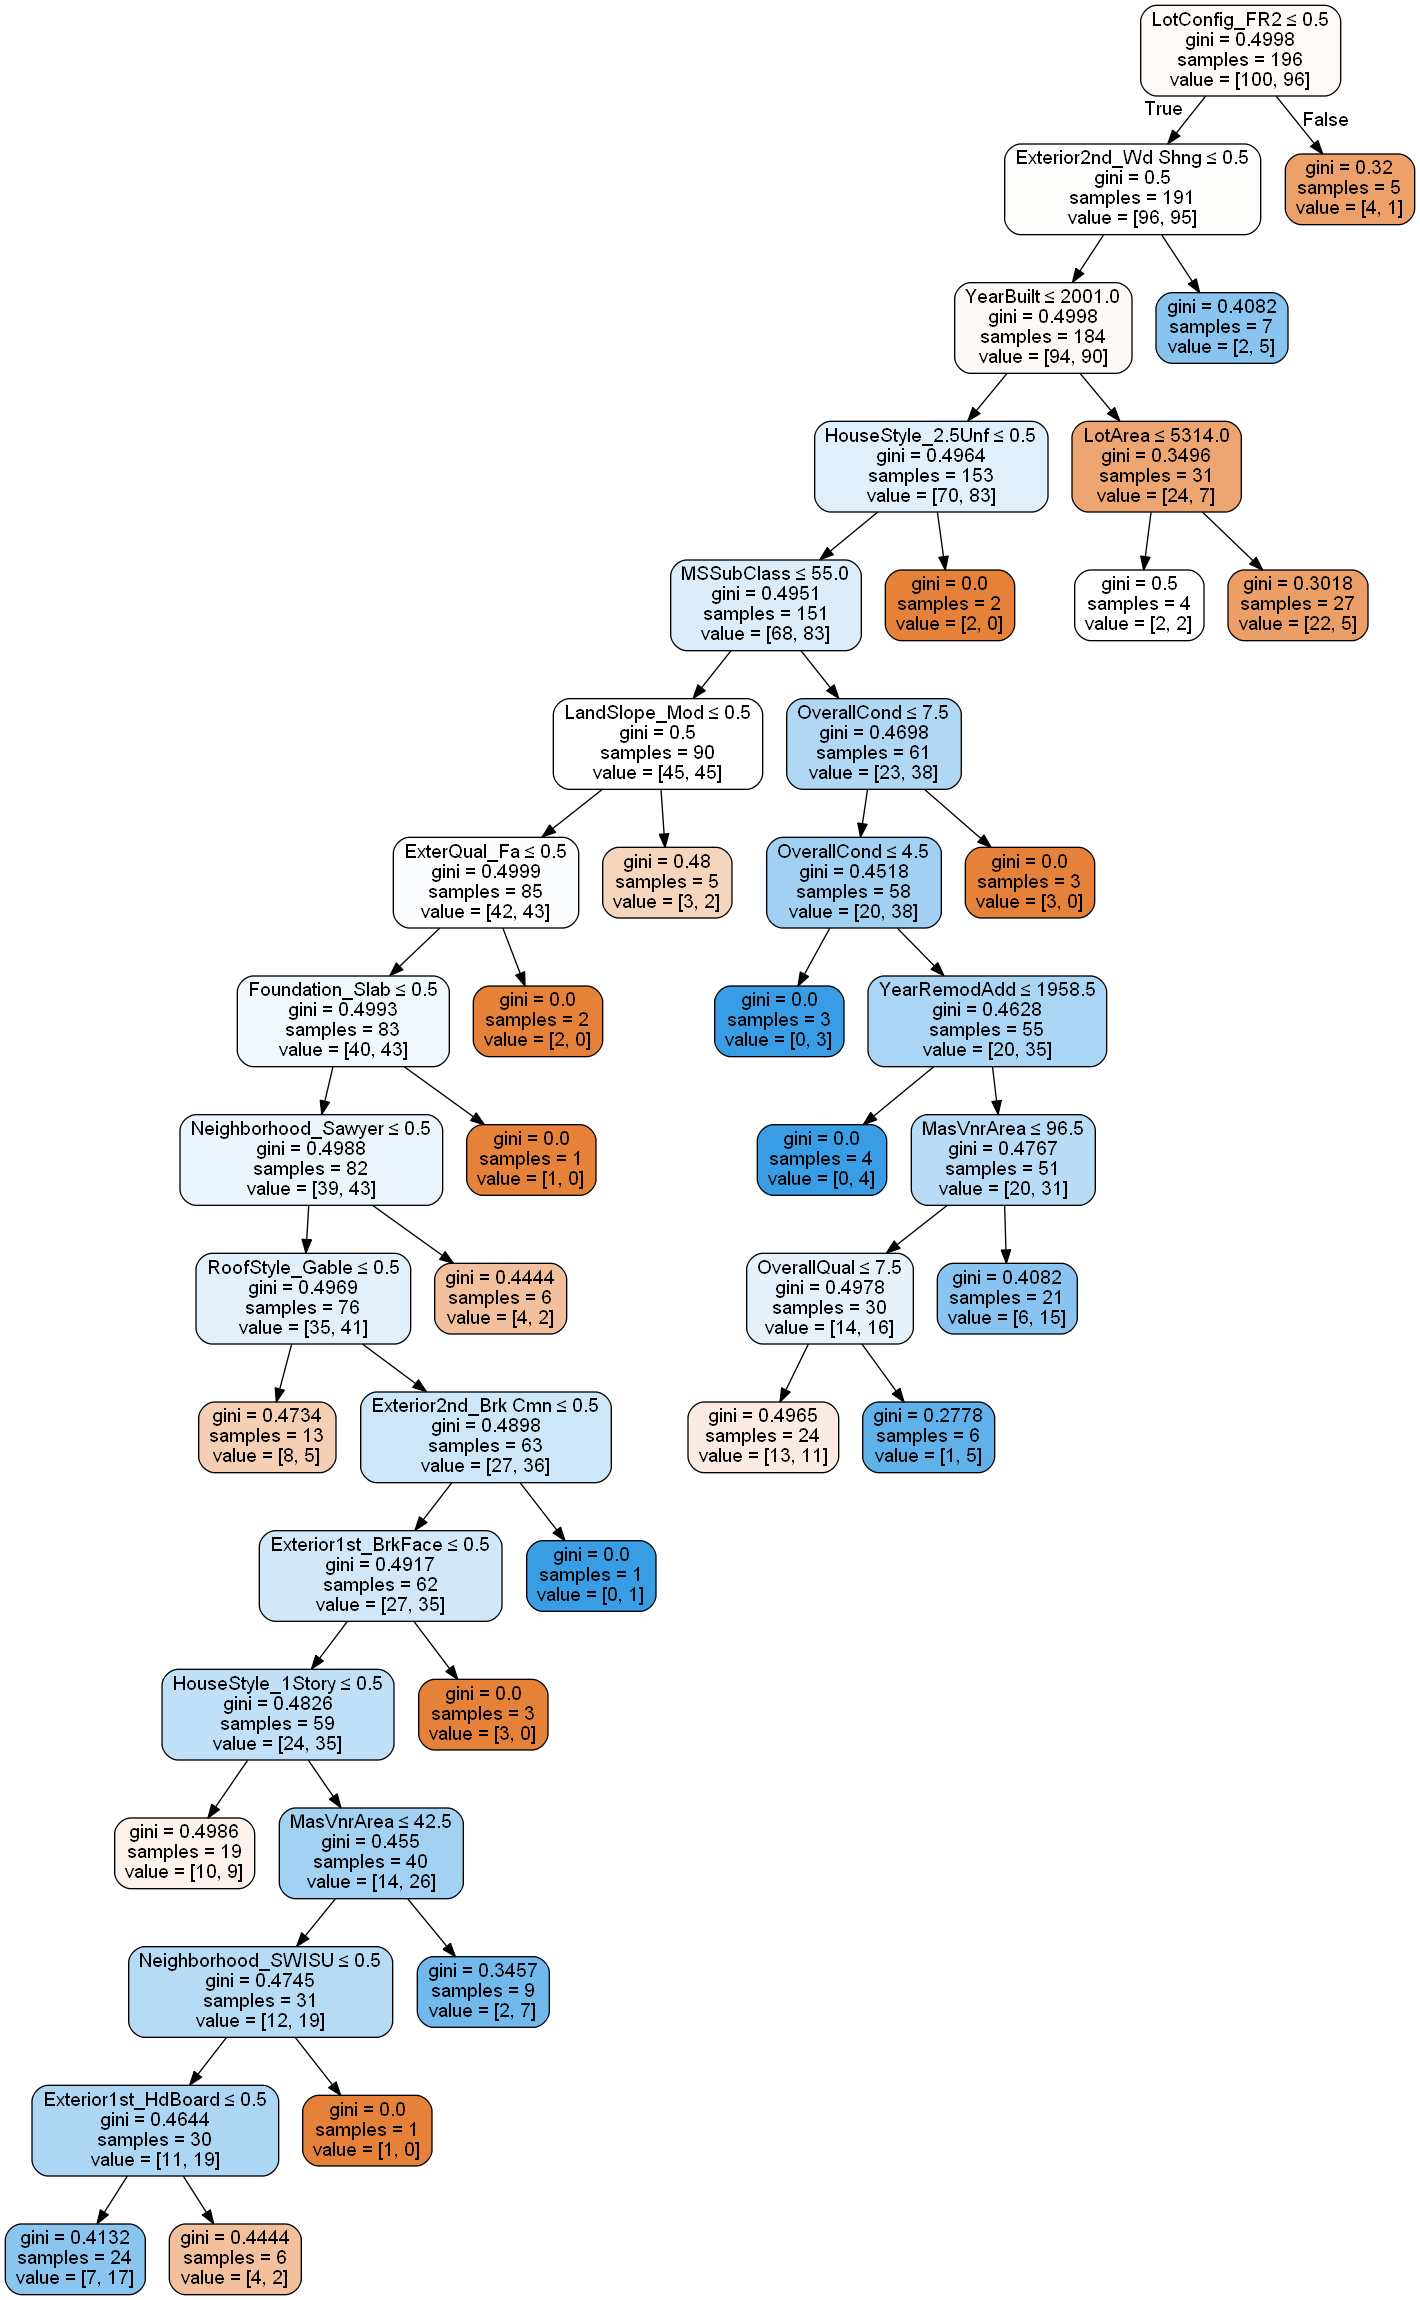

In [87]:
# plot the decision tree
# how come the decision tree looks different from the important features???
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

# initialize the output file object
dot_data = StringIO() 

export_graphviz(dtclass, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  